Classification and model selection


# Classifier comparison

Classification is a supervised learning technique that organizes observations into categories. 

SKlearn has a variety of robust classification techniques, some of which include:
* **Logistic Regression**: Fits by using a logistic function to model the probability of a binary outcome. Its advantage is simplicity and interpretability for binary classification problems.
* **Support Vector Machines (SVM)**: Fits by finding the hyperplane that best separates different classes with the maximum margin. Its advantage is effectiveness in high-dimensional spaces.
* **Stochastic Gradient Descent (SGD)**: Fits by iteratively minimizing the loss function, useful for large-scale and sparse data. Its advantage is efficiency and customizability.
* **Random Forest**: Fits by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes of the individual trees. Its advantage is robustness to overfitting and ability to handle unbalanced data.
* **Naive Bayes**: Fits by applying Bayes' theorem with the assumption of independence between features. Its advantage is efficiency and performance, especially in text classification and with large datasets.

When doing model selection, often a data scientist will look to test multiple algorithms. To demonstrate how MLflow can faciliate this process of model selection, we will modify the [SKlearn Classifier Comparison Demo](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) to leverage MLflow.

In [1]:
!pip install --upgrade mlflow

In [9]:
import datetime
import mlflow
mlflow.autolog(log_input_examples=True)

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import subprocess
import warnings

np.random.seed(42) # Set a numpy random seed for reproducibility

### 1 - Define Classifiers to Test

Our first step will be to define our classifiers of interest. As noted above, each have their pros and cons, so we're going to let our validation method speak for itself. 

In [3]:
classifier_names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(algorithm="SAMME", random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]


### 2 - Create Datasets

To properly test our models, let's leverage three different datasets.
1. `make_moons`: a dataset that shows a complex non-linear relationship
2. `make_circles`: a dataset that has classes nested within overlayed circles
3. `linearly_separable`: a dataset that can be separated by a line

In [4]:
X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

dataset_names = {i: v for i,v in zip(list(range(3)), ["moons","circles","linearly separable"])}

### 3 - Modeling Process

Now that we have models of interst and sample datasets, let's fit our models to these datasets and observe the ouptuts.

Structuring model comparison in MLflow is very straight forward and can be done several ways. For simplicity, we create a single [experiment](https://mlflow.org/docs/latest/getting-started/logging-first-model/step3-create-experiment.html) to logically group our model trainings under a single organizing _umrella_. Then, for each training run which will have a unique model and dataset combination, we'll create individual runs within the experiment. 

2024/02/28 20:20:51 INFO mlflow.tracking.fluent: Experiment with name '/Users/michael.berk@databricks.com/Classifier Comparison' does not exist. Creating a new experiment.
2024/02/28 20:20:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/michael.berk/opt/anaconda3/envs/mlflow-dev-1/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
/Users/michael.berk/opt/anaconda3/envs/mlflow-dev-1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


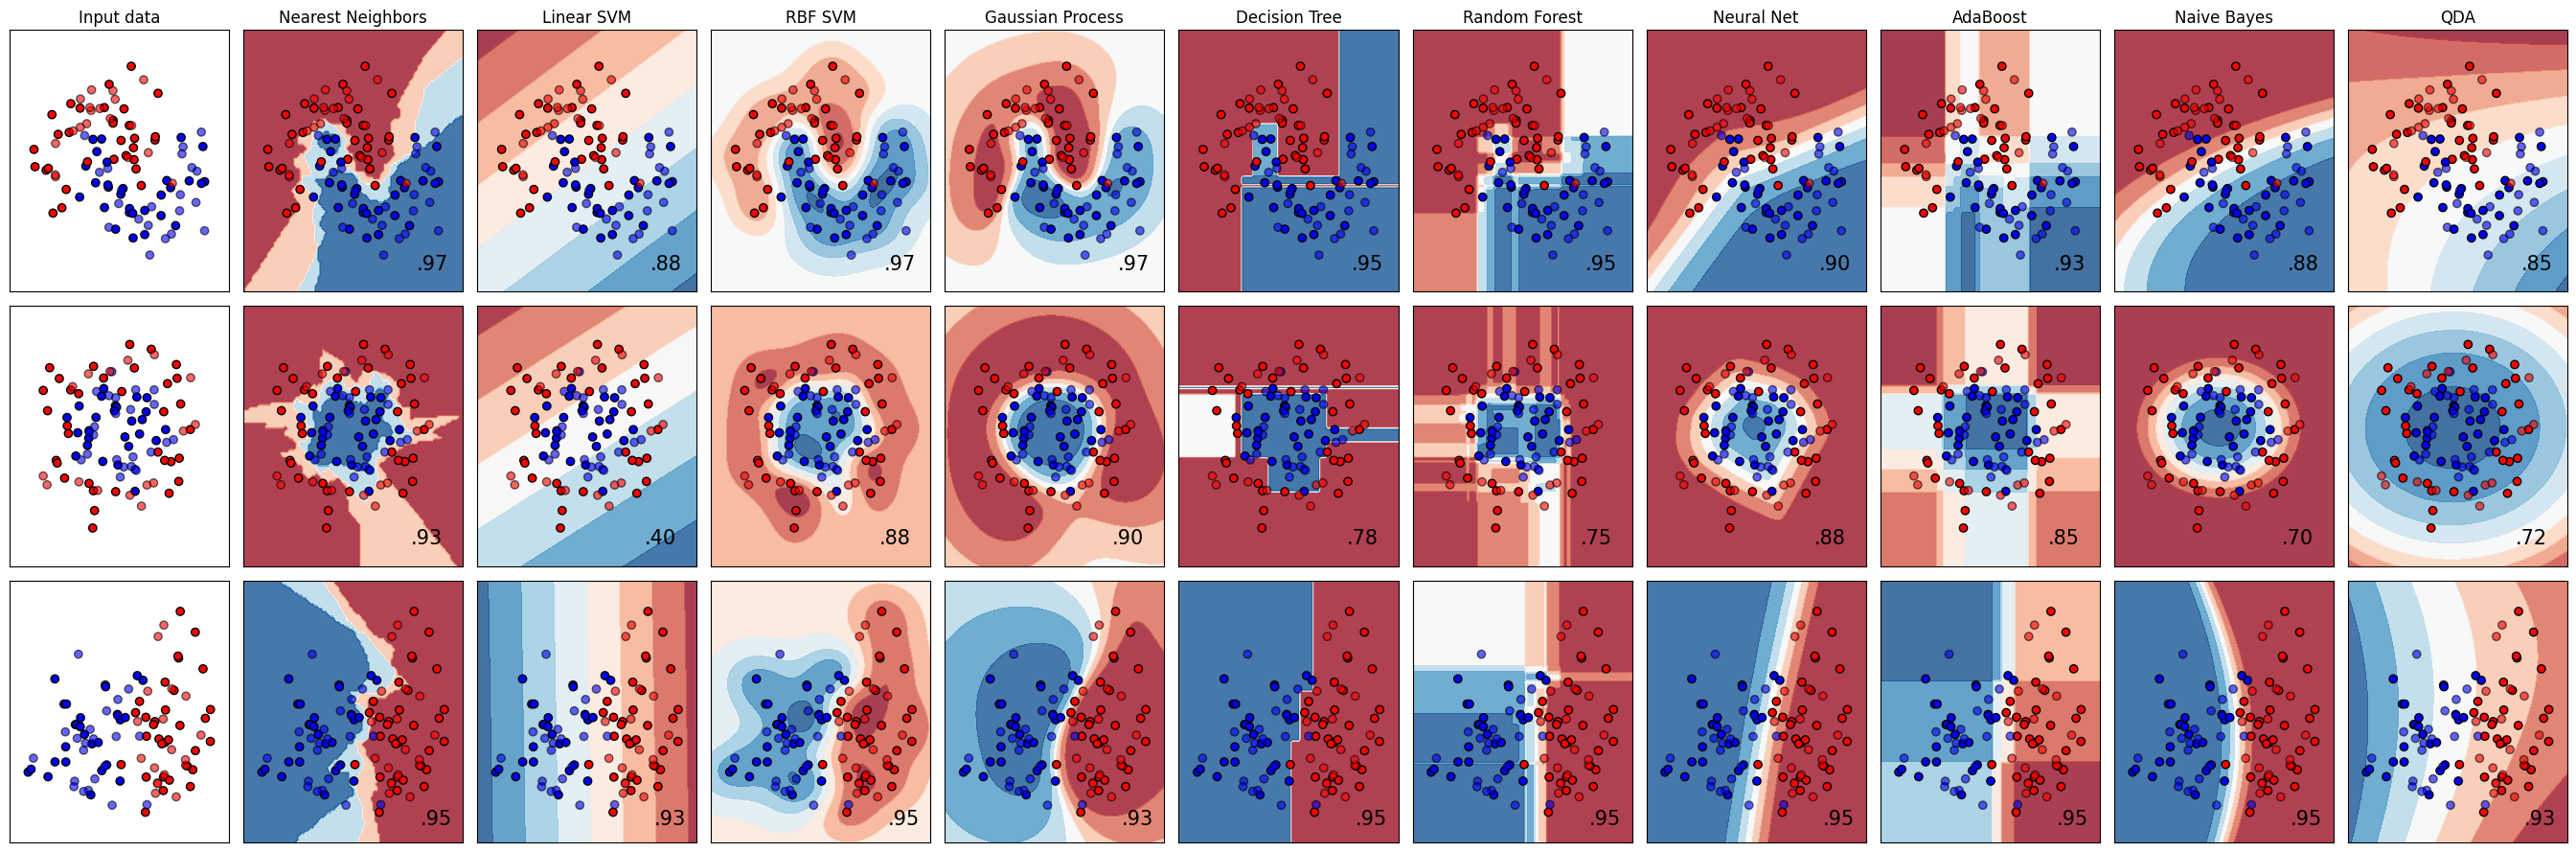

In [5]:
# Enable autologging 
mlflow.sklearn.autolog()

# Create a new experiment with relevant tags and information
now = datetime.datetime.now()
experiment_name = "Classifier Comparison" 

mlflow.set_experiment(experiment_name)
mlflow.set_experiment_tags(
    tags={
        "project_name": "SKU classification",
        "project_owner": "manager@company.com",
        "team": "supply-chain",
        "project_quarter": f"Q{(now.month-1)//3 + 1}-{now.year}",
        "mlflow.note.content": (
            f"""Compare {classifier_names} classification models on moons, circles, and linearly separable."""
        ),
    },
)

# Run our comparison
figure = plt.figure(figsize=(27, 9))
i = 1

for ds_cnt, ds in enumerate(datasets):
    # Preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # Plot the raw dataset
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")

    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # Iterate over classifiers
    for name, clf in zip(classifier_names, classifiers):
        with mlflow.start_run():

            # Log run information
            mlflow.log_param("dataset_name", dataset_names[ds_cnt])
            mlflow.log_param("model_name", name)
        
            # Insert chart to the main figure
            ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

            clf = make_pipeline(StandardScaler(), clf)
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)
            DecisionBoundaryDisplay.from_estimator(
                clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
            )

            ax.scatter(
                X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
            )
            ax.scatter(
                X_test[:, 0],
                X_test[:, 1],
                c=y_test,
                cmap=cm_bright,
                edgecolors="k",
                alpha=0.6,
            )

            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)
            ax.set_xticks(())
            ax.set_yticks(())
            if ds_cnt == 0:
                ax.set_title(name)
            ax.text(
                x_max - 0.3,
                y_min + 0.3,
                ("%.2f" % score).lstrip("0"),
                size=15,
                horizontalalignment="right",
            )
            i += 1

plt.tight_layout()
plt.show()

### 4 - Compare Model Runs

Now that we have multiple model runs, each of which correspond to a unique model trained on a unique dataset, we can compare performance in a variety of ways.

#### 4.1 - Leverage the Chart Above

#### 4.2 - Leverage the MLflow UI

Our first step is to start the MLflow server. This UI will read from the ``mlruns`` directory created
in the current working directory. By default, it will start a server at ``http://localhost:5000/``.

In [ ]:
subprocess.call(["mlflow","server"])

With the server active, let's navigate to our experiment runs.
1. Navigate to the ``Experiments`` tab, which can be found on the header.
2. Navigate to our experiment of interest. In our case, it will take the value of our global variable ``EXPERIMENT_NAME``.
3. Click on an experiment run.
4. Observe the logged information.

By relying on MLflow autologging, you'll notice we have 1 dataset, 12 parameters, 8 metrics, 2 tags, and 6 core artifacts. 

Finally, before querying this data, go back to the experiment of interest by clicking on our experiment name
at the top of the page. Let's observe some visualizations automatically created.
1. Click on the "Chart" button above our runs.
2. Observe the metric plots.
3. For a metric plot of interest, for example ``training_f1_score``, click on the three dots in the 
    top right corner of the chart then click ``Configure``
4. Increase the ``Max. no of runs shown:`` to 100, which will display all our runs.

With all values plotted, in a bar chart, you should be able to easily identify outlier model runs.

#### 4.3 - Leverage Logged Metrics by Run

If you're looking to automate model selection, because we aggregated our runs into a single experiment, you can easily pull logged metrics for each run. Let's populate a pandas DataFrame with these performance metrics.

In [12]:
runs_pdf = mlflow.search_runs(experiment_names=[experiment_name])
runs_summary_pdf = runs_pdf[["run_id","metrics.training_recall_score", "metrics.training_precision_score", "metrics.training_f1_score", "params.model_name", "params.dataset_name"]]
runs_summary_pdf = runs_summary_pdf.sort_values(["metrics.training_recall_score", "metrics.training_precision_score"], ascending=False)

runs_summary_pdf

,run_id,metrics.training_recall_score,metrics.training_precision_score,metrics.training_f1_score,params.model_name,params.dataset_name
2,05836edefaf145b48e9875471e8b9b49,1.000000,1.000000,1.000000,AdaBoost,linearly separable
4,09f21bc85b0740628b5d3bdef69dd837,1.000000,1.000000,1.000000,Random Forest,linearly separable
5,322e5cab1b67405eaab979fc7ba6f659,1.000000,1.000000,1.000000,Decision Tree,linearly separable
6,f394e6a193fd4f8a8d53258e986be1dc,1.000000,1.000000,1.000000,Gaussian Process,linearly separable
22,5369bda798aa43cea14b25e885dc6dcc,1.000000,1.000000,1.000000,AdaBoost,moons
7,b9f1ea6b79ae44fea37e23ca6a0f9b5d,0.983333,0.983908,0.983347,RBF SVM,linearly separable
9,eefea096d84a40e3bb11609ec69168e1,0.983333,0.983908,0.983347,Nearest Neighbors,linearly separable
25,5e5b1d5038e7477fbd36966e264761ba,0.983333,0.983889,0.983338,Decision Tree,moons
26,9c7d8b8be7f1407b9c45f1a7dafc0fe8,0.983333,0.983889,0.983338,Gaussian Process,moons
15,1ab5ae577ba94a32a05afc70b539e807,0.983333,0.983810,0.983291,Decision Tree,circles


In [ ]:
runs_pdf